In [431]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split


from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score,accuracy_score,classification_report,roc_curve,confusion_matrix
from sklearn.impute import SimpleImputer
pd.set_option('display.max_columns',None)

In [432]:
data_train = pd.read_csv('../titanic/train.csv')
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [433]:
data_test = pd.read_csv('../titanic/test.csv')
data_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [434]:
#shape of training dataset
data_train.shape

(891, 12)

In [435]:
#checking for null values
data_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [436]:
data_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [437]:
#Removing the Cabin and Name column from train and test data since there are many null values
data_train.drop(columns =['Cabin','Name'], inplace = True)
data_test.drop(columns=['Cabin','Name'], inplace = True)

In [438]:
#Splitting the dataset in feature and target variable
X = data_train.drop(columns = 'Survived')
y = data_train['Survived'].copy()

In [439]:
#checking for null values
X.isnull().sum()

PassengerId      0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         2
dtype: int64

In [440]:
#Imputing Embarked and Age columns with most frequent

imp = SimpleImputer(missing_values=np.nan,strategy='most_frequent')
X['Age'] = imp.fit_transform(X[['Age']])
X['Embarked'] = imp.fit_transform(X[['Embarked']])

#Imputing in testing data as well
data_test['Age'] = imp.fit_transform(data_test[['Age']])
data_test['Embarked'] = imp.fit_transform(data_test[['Embarked']])
data_test['Fare'] = imp.fit_transform(data_test[['Fare']])

In [441]:
#checking data types of each columns
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
PassengerId    891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Embarked       891 non-null object
dtypes: float64(2), int64(4), object(3)
memory usage: 62.8+ KB


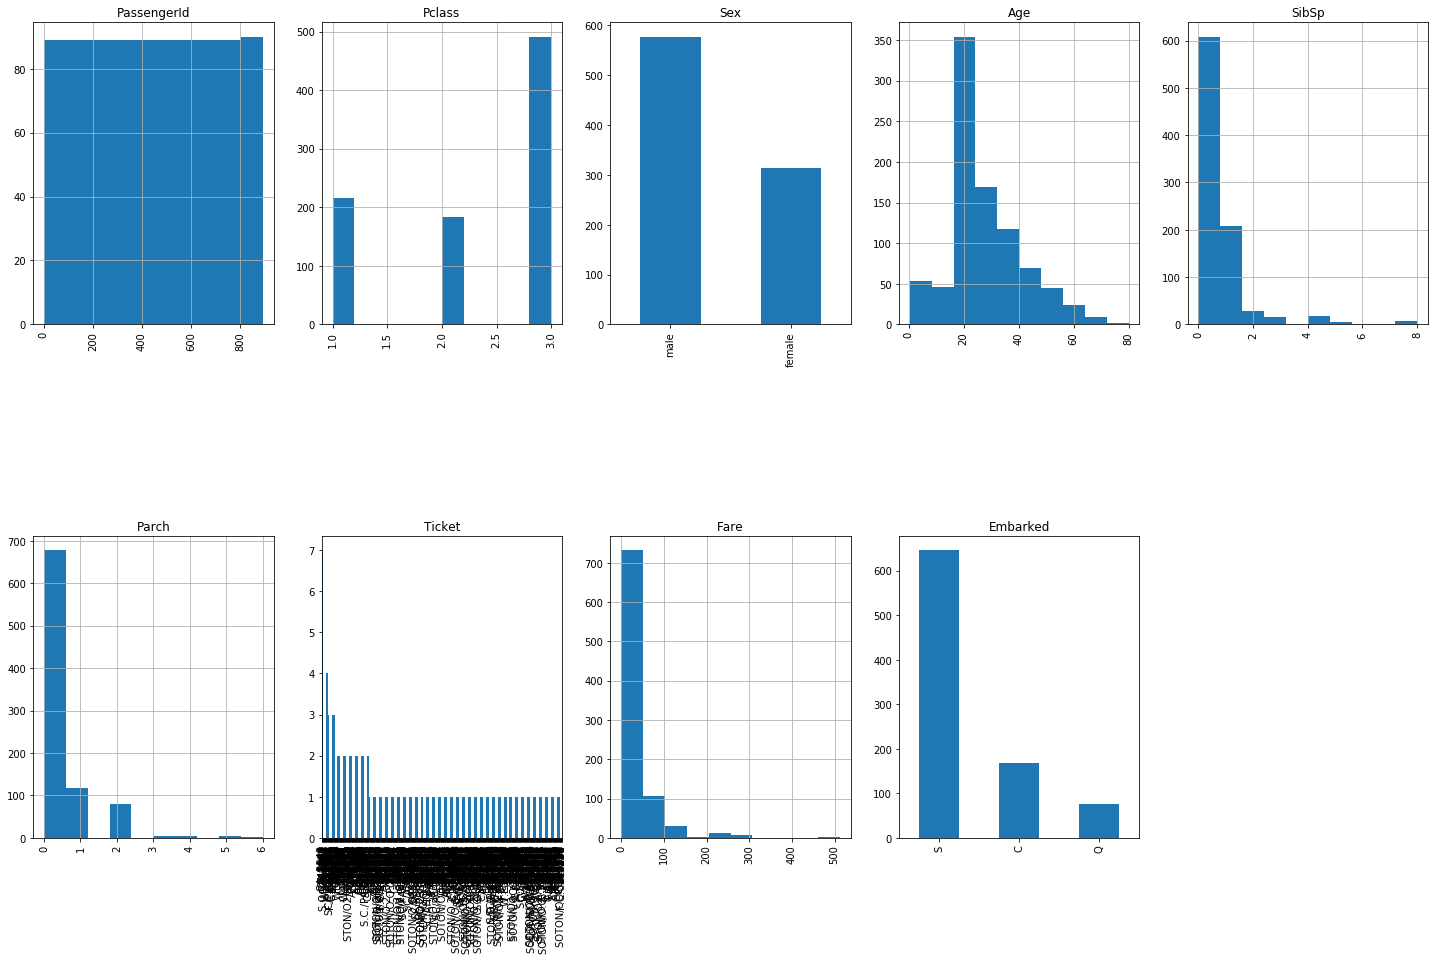

In [442]:
fig = plt.figure(figsize=(25, 15))
cols = 5
rows = np.ceil(float(X.shape[1]) / cols)
for i, column in enumerate(X.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if  X.dtypes[column] == np.object:
        X[column].value_counts().plot(kind="bar", axes=ax)
    else:
        X[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

In [443]:
#Removing ticket and passenger id columns
X.drop(columns =['Ticket','PassengerId'], inplace = True)
data_test1 = data_test.drop(columns=['Ticket','PassengerId'])

In [444]:
#Separating categorical and continuous variables
X_cat = X.select_dtypes(include='object')
X_cont = X.select_dtypes(exclude='object')

In [445]:
#checking skewness
for i in X_cont:
    print(i, X_cont[i].skew())

Pclass -0.6305479068752845
Age 0.6577529069911331
SibSp 3.6953517271630565
Parch 2.7491170471010933
Fare 4.787316519674893


In [446]:
#Removing skewness
for feature in X_cont:
    if abs(X_cont[feature].skew())> 1:
        X_cont[feature] = X_cont[feature].apply(np.log1p)
        data_test1[feature] = data_test1[feature].apply(np.log1p)

In [447]:
#checking skewness
for i in X_cont:
    print(i, X_cont[i].skew())

Pclass -0.6305479068752845
Age 0.6577529069911331
SibSp 1.6612454204052132
Parch 1.6754394553891907
Fare 0.3949280095189306


In [448]:
#Encoding the categorical variables

le = LabelEncoder()
for i in X_cat:
    X_cat[i] = le.fit_transform(X_cat[i])
for j in data_test1.select_dtypes(include='object'):
    data_test1[j] = le.fit_transform(data_test1.select_dtypes(include='object')[j])

In [449]:
data_test1.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,34.5,0.000000,0.000000,2.178064,1
1,3,0,47.0,0.693147,0.000000,2.079442,2
2,2,1,62.0,0.000000,0.000000,2.369075,1
3,3,1,27.0,0.000000,0.000000,2.268252,2
4,3,0,22.0,0.693147,0.693147,2.586824,2


In [450]:
#Training dataset
X_train = pd.concat([X_cat,X_cont],axis=1, sort=False)
X_train.head()

,Sex,Embarked,Pclass,Age,SibSp,Parch,Fare
0,1,2,3,22.0,0.693147,0.0,2.110213
1,0,0,1,38.0,0.693147,0.0,4.280593
2,0,2,3,26.0,0.000000,0.0,2.188856
3,0,2,1,35.0,0.693147,0.0,3.990834
4,1,2,3,35.0,0.000000,0.0,2.202765


In [451]:
#Applying Logistic  Regression
logreg = LogisticRegression()
logreg.fit(X_train,y)
y_pred = logreg.predict(data_test1)
score_lr = logreg.score(X_train,y)
print('Score for Logistic Regression', score_lr)


Score for Logistic Regression 0.7901234567901234


In [452]:
#Applying Decision Tree
dt = DecisionTreeClassifier(max_depth=3,random_state=42)
dt.fit(X_train,y)
y_pred1 = dt.predict(data_test1)
score_dt = dt.score(X_train,y)
print('Score for Decision Tree', score_dt)

Score for Decision Tree 0.8271604938271605


In [453]:
#Naive aggregation
from sklearn.ensemble import VotingClassifier

# Various models
clf_1 = LogisticRegression()
clf_2 = DecisionTreeClassifier(random_state=4)
clf_3 = RandomForestClassifier(random_state=4)

model_list = [('lr',clf_1),('DT',clf_2),('RF',clf_3)]

#Hard voting
voting_clf_hard = VotingClassifier(estimators=model_list,voting='hard')

# Fit the model on training data
voting_clf_hard.fit(X_train,y)
score_hard = dt.score(X_train,y)
print('Score for Hard Voting ', score_hard)


#Soft Voting
voting_clf_soft = VotingClassifier(estimators=model_list,voting='soft')

# Fit the model on training data
voting_clf_soft.fit(X_train,y)
score_soft = dt.score(X_train,y)
print('Score for Soft Voting ', score_soft)

Score for Hard Voting  0.8271604938271605
Score for Soft Voting  0.8271604938271605


In [454]:
#Hyperparameter Tuning
rfc = RandomForestClassifier(random_state=2)
param_grid = { 
'n_estimators': [6,7,8],
'max_features': ['auto', 'sqrt', 'log2'],
'max_depth' : [6,7,8,9,10],
'criterion' :['gini', 'entropy']
}
grid_search_model = GridSearchCV(rfc, param_grid=param_grid)
grid_search_model.fit(X_train, y)

grid_search_model.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 7}

In [475]:
#Applying Random Forest
rfc1 = RandomForestClassifier(random_state=6,criterion = 'entropy',max_depth = 8,max_features='auto',n_estimators=7)
rfc1.fit(X_train,y)
y_pred2 = rfc1.predict(data_test1)
score_rfc = rfc1.score(X_train,y)
print('Score for Random Forest ', score_rfc)

Score for Random Forest  0.9001122334455668


In [476]:
df = pd.DataFrame({'Survived':np.array(y_pred2)})
df['Survived'].value_counts()

0    302
1    116
Name: Survived, dtype: int64

In [477]:
test_dataset = pd.concat([data_test['PassengerId'],df],axis=1,sort=False)
test_dataset.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0


In [478]:
# Submission CSV file
submit = test_dataset
submit.to_csv('titanic submission.csv', index = False)